# **Medical Cost Prediction --- Can we accurately predict medical costs based on people’s data?**

# Introduction

Health issues can arise suddenly and unexpectedly, leading to a lot of stress for those affected. Financial stress is a big part of that; healthcare in the United States is expensive, and an issue can quickly leave a person or family running low on money. Insurance companies exist to mitigate these concerns by using financial capital to reimburse those who find themselves in such a scenario (1, 2). However, insurance companies need to collect more than they spend on the medical care of their beneficiaries to not lose money themselves. To do that, they use historical data to sufficiently and precisely measure the amount of the medical costs covered by the insurance charges of each beneficiary (1, 2). The medical insurers' main job is to correctly anticipate insurance policy costs, develop accurate pricing models, plan a particular insurance outcome, and manage an extensive portfolio based on their data analysis of individual insurance records (1).

Our dataset "Insurance.csv" is taken from Kaggle, and it contains 1,339 insurance records from the past, including age, gender, family status, Body Mass Index, smoking or not, etc. We will train a multiple linear regression model that generates the target individual medical charges more accurately with various factors influencing an individual's health status as model inputs. Additionally, we will determine what the most correlated variables influencing insurance costs are. Our final objective is to predict insurance charges based on our fitted model from the training set using the test set. According to our results, the insurance company can then set the price of yearly premiums higher or lower.

In [37]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(funModeling) 
library(Hmisc)
library(GGally)
library(car)
library(janitor)
library(scales)
library(car)
library(glmnet)
library(Metrics)
library(class)
library(caret)

In [2]:
data<- read.csv("https://raw.githubusercontent.com/Zibo-S/STAT301_GP_4/main/insurance.csv", header= TRUE)

In [3]:
data%>%head(3)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.90,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.552
3,28,male,33.00,3,no,southeast,4449.462


## Methods: Plan

### **Maybe look into log regression because prices might increase a % based on factors instead of linearly**

We plan to use LASSO to fit a linear regression to predict the charges someone might have to pay given different parameters. Because we are using LASSO(3) to find the most accurate model, we do not know what these parameters will be, but we know that they will be a subset of the ones mentioned earlier.

We can then quantify the model's performance by calculating the mean squared error (MSE) that it achieves on the training set. With this, we expect to achieve a model capable of predicting the charges of a patient, which can give more insight into what factors influence charges the most and allow patients to predict the average price that they might have to pay for a visit to the hospital.

**1. split data into training and testing sets (70% vs 30%)**

In [4]:
# split data into training and testing sets
set.seed(1234)

data$ID <- 1:nrow(data)
training_set <- sample_n(data, size = nrow(data) * 0.70,
  replace = FALSE
)

testing_set <- anti_join(data,
  training_set,
  by = "ID"
)

head(training_set, 3)
nrow(training_set)

head(testing_set, 3)
nrow(testing_set)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,32,male,28.12,4,yes,northwest,21472.479,1308
2,26,female,34.20,2,no,southwest,3987.926,1018
3,23,female,42.75,1,yes,northeast,40904.200,1125


[1] 936

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


[1] 402

Check data balancing for our target variable Charges by histogram.

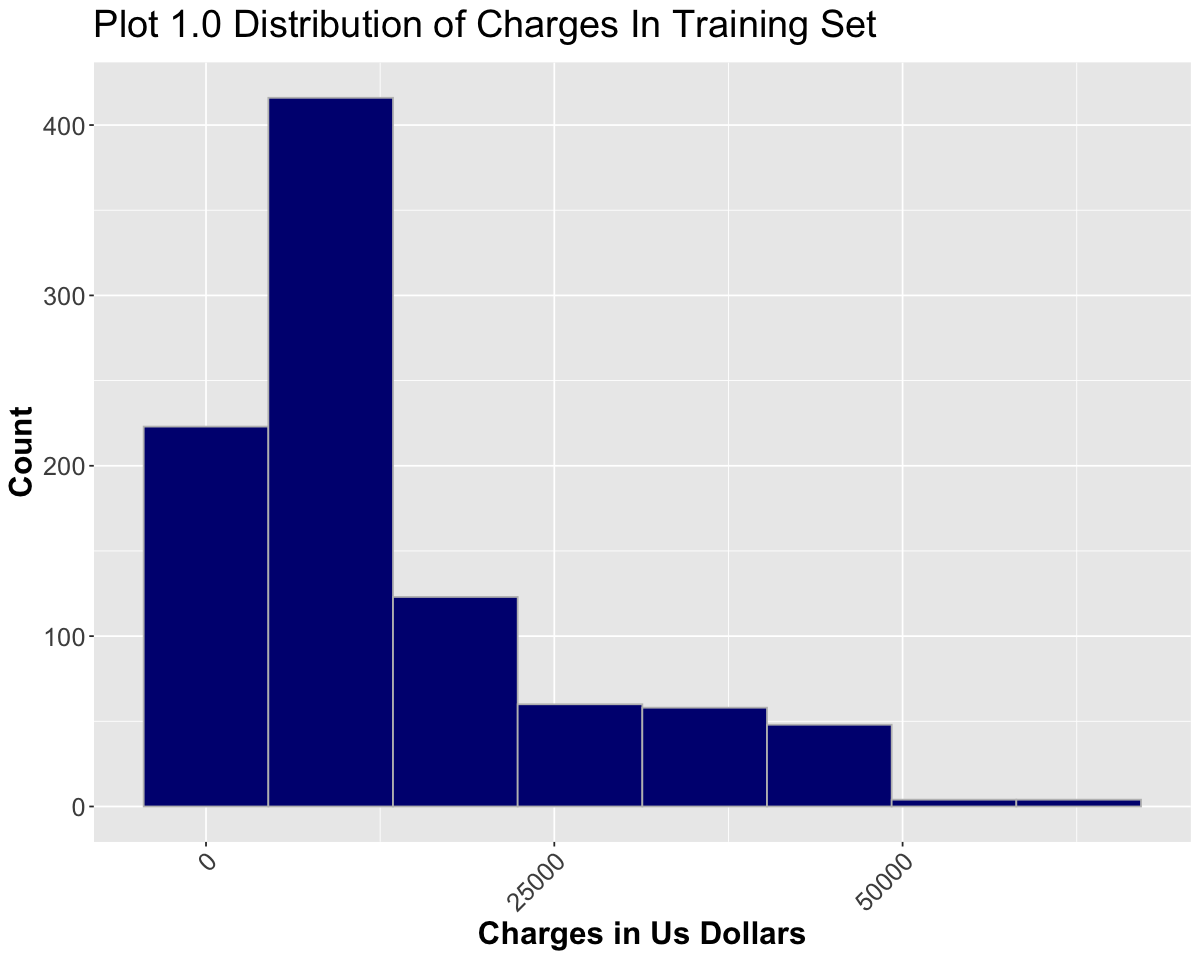

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_charges <- ggplot(training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot 1.0 Distribution of Charges In Training Set"))
hist_charges

As we can see, there are less count for chargers over $25000, which make sense, since less people are being charged for higher amount.

**2. Perform Data tranformation to the training dataset**

In this project, a `log-transformation` is performed to all the numeric variables, for the purpose of reduces or removes the skewness of our training data.<br>
Since glmnet cannot handle categorical variables directly, transferring categorical variables to a binary representation. 

In [6]:
# drop feature 'ID' since it is irrelevant to our target
training_set=training_set[-8]

In [7]:
# log the charge 
tran_training_set<- training_set %>% mutate(sex = factor(sex),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges)
                                           )
# 0 for female and 1 for male
levels(tran_training_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_training_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_training_set$region) <- c(0,1,2,3)

tran_training_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<dbl>
1,32,1,28.12,4,1,1,9.974527
2,26,0,34.20,2,0,3,8.291027
3,23,0,42.75,1,1,0,10.618988
4,48,1,29.60,0,0,3,9.963273
5,49,0,21.30,1,0,3,9.125019


Check data balancing again using transfered target variable Charges by histogram.

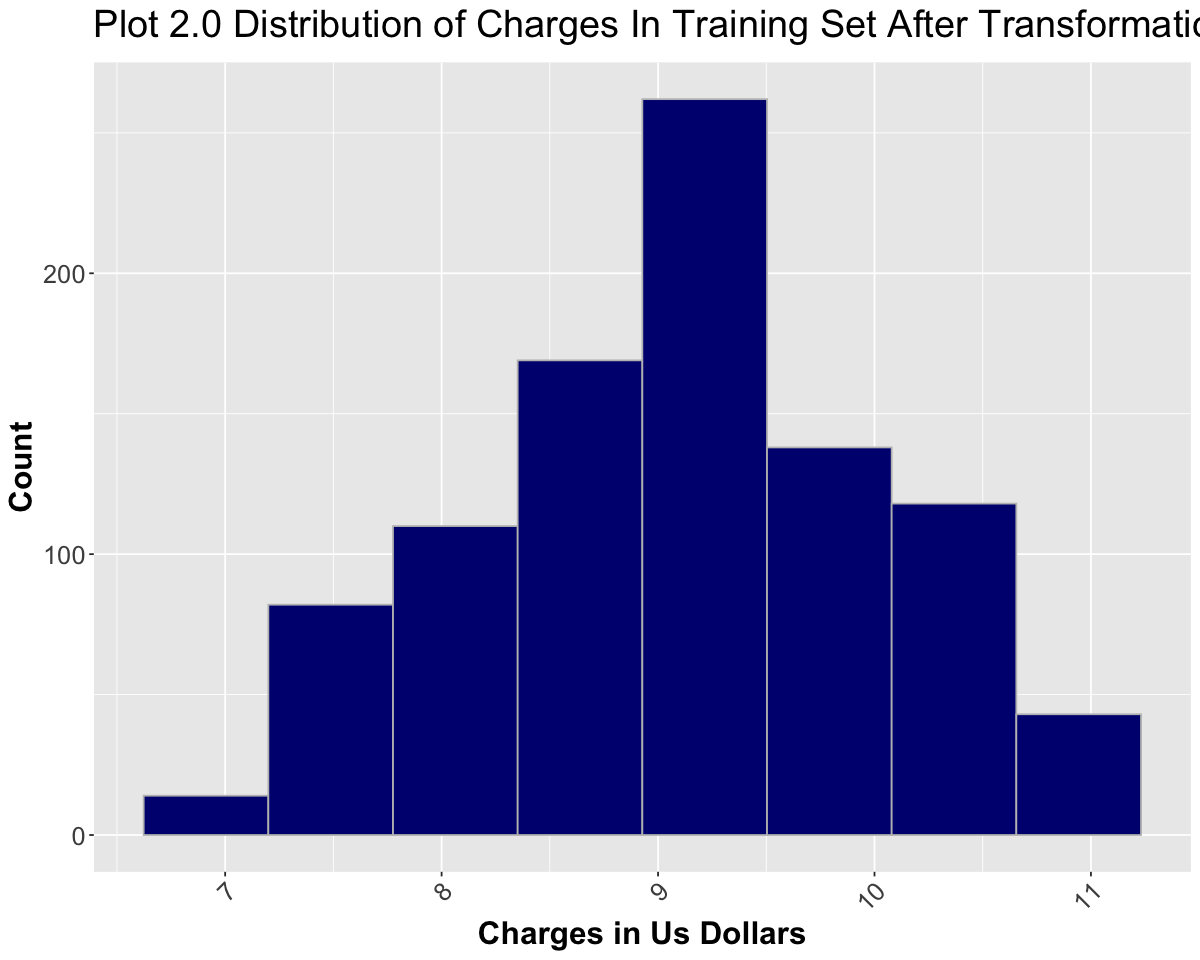

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_tran_charges <- ggplot(tran_training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot 2.0 Distribution of Charges In Training Set After Transformation"))
hist_tran_charges

From the plot above, the distribution of our transferred target variable is more Normally distributed.

**3. Model Selection by using Lasso**

10 fold cross-validation is carried out to find the best model

Code Reference: <br>
https://stats.stackexchange.com/questions/72251/an-example-lasso-regression-using-glmnet-for-binary-outcome

In [9]:
set.seed(1234)
x_train <-model.matrix(tran_training_set$charges~tran_training_set$age+tran_training_set$sex+tran_training_set$bmi+tran_training_set$children+tran_training_set$smoker+tran_training_set$region)[,-1]
lasso_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=1, nfolds=10)
lasso_model


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.00133    67  0.2115 0.01199       8
1se 0.04569    29  0.2234 0.01351       4

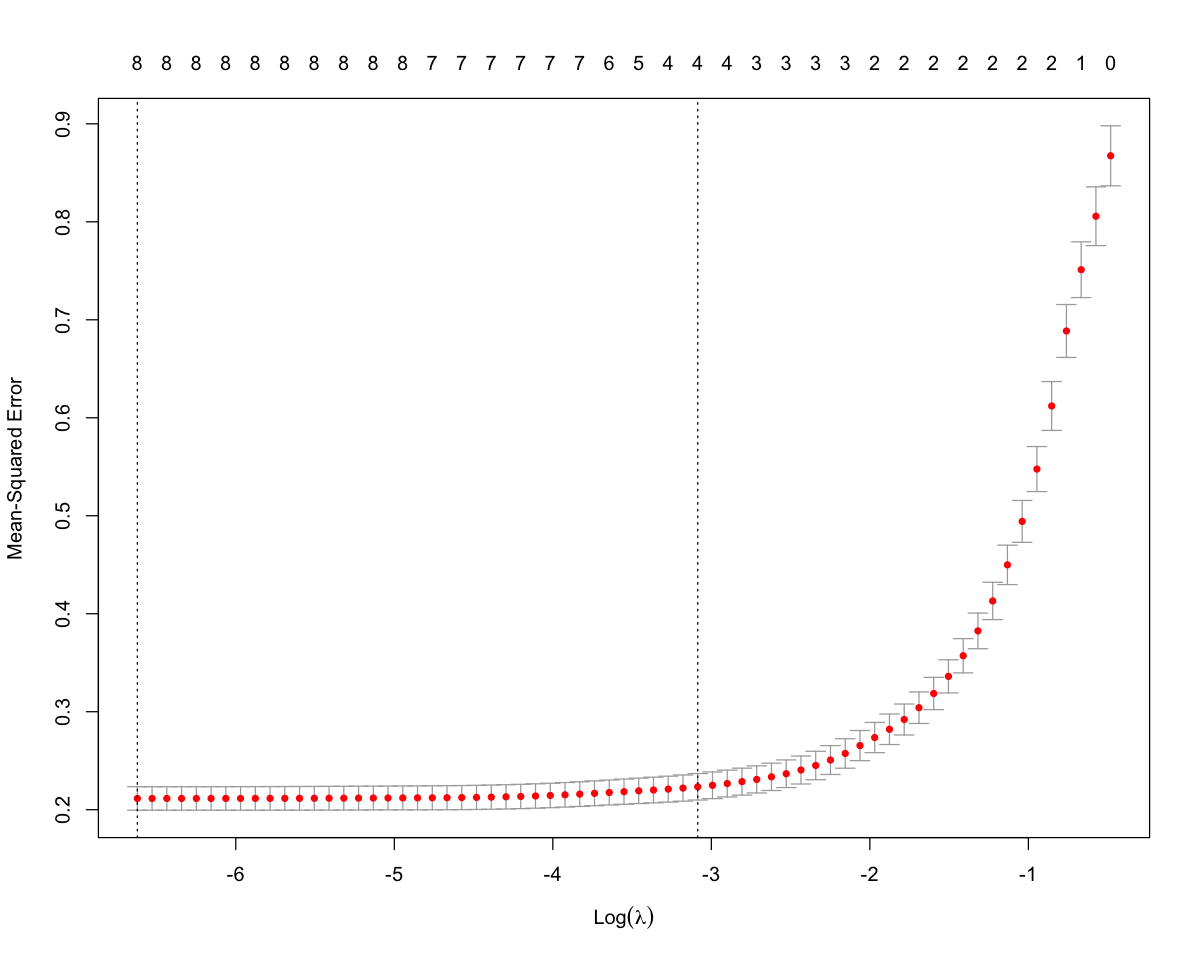

In [10]:
plot(lasso_model)

In [11]:
# TODO: Add plot discription 

In [12]:
best_lambda <- lasso_model$lambda.min
best_lambda

[1] 0.001331958

Making a new Lasso model with the minimized lambda

In [13]:
best_model<-glmnet(x=x_train,y =tran_training_set$charges,alpha=1, lambda=best_lambda)

In [14]:
set.seed(1234) # do not change this
beta_lasso<-lasso_model%>%coef(s = best_lambda)
beta_lasso

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)                 7.05186513
tran_training_set$age       0.03453083
tran_training_set$sex1     -0.06464285
tran_training_set$bmi       0.01251814
tran_training_set$children  0.10935674
tran_training_set$smoker1   1.57937243
tran_training_set$region1  -0.04909121
tran_training_set$region2  -0.17126784
tran_training_set$region3  -0.12046990

In [15]:
# tidy the model to a more readable formet
best_model


Call:  glmnet(x = x_train, y = tran_training_set$charges, alpha = 1,      lambda = best_lambda) 

  Df  %Dev   Lambda
1  8 76.08 0.001332

In [16]:
lasso_variables_vif<-vif(lm(tran_training_set$charges ~.,tran_training_set))
lasso_variables_vif

,GVIF,Df,GVIF^(1/(2*Df))
age,1.019606,1,1.009755
sex,1.014185,1,1.007068
bmi,1.162409,1,1.078151
children,1.012593,1,1.006277
smoker,1.014577,1,1.007262
region,1.156721,3,1.024562


The `lasso_variables_vif` does not indicate a very concerning presence of multicollinearity. 

In [17]:
# to do: model explination 

**4. Predict on testing set**

4.1 feature transformation on testing set

In [18]:
testing_set%>%head(3)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


In [19]:
testing_set=testing_set[-8]


tran_testing_set<- testing_set %>% mutate(sex = factor(sex),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges),
                                           )

# 0 for female and 1 for male
levels(tran_testing_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_testing_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_testing_set$region) <- c(0,1,2,3)


In [20]:
x_test <-model.matrix(tran_testing_set$charges~tran_testing_set$age+tran_testing_set$sex+tran_testing_set$bmi+tran_testing_set$children+tran_testing_set$smoker+tran_testing_set$region)[,-1]

predictions<- predict(best_model, newx = x_test, s = "lambda.min")

x_test%>%head(3)

,tran_testing_set$age,tran_testing_set$sex1,tran_testing_set$bmi,tran_testing_set$children,tran_testing_set$smoker1,tran_testing_set$region1,tran_testing_set$region2,tran_testing_set$region3
1,28,1,33.00,3,0,0,1,0
2,32,1,28.88,0,0,1,0,0
3,37,0,27.74,3,0,1,0,0


In [21]:
actual = tran_testing_set$charges
prediction = predictions
rmse(actual,prediction)

[1] 0.4129776

In [22]:
# Testing rmse is smaller

**5. Ridge for comparison**


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 0) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.06182   100  0.2140 0.01149       8
1se 0.14282    91  0.2235 0.01146       8

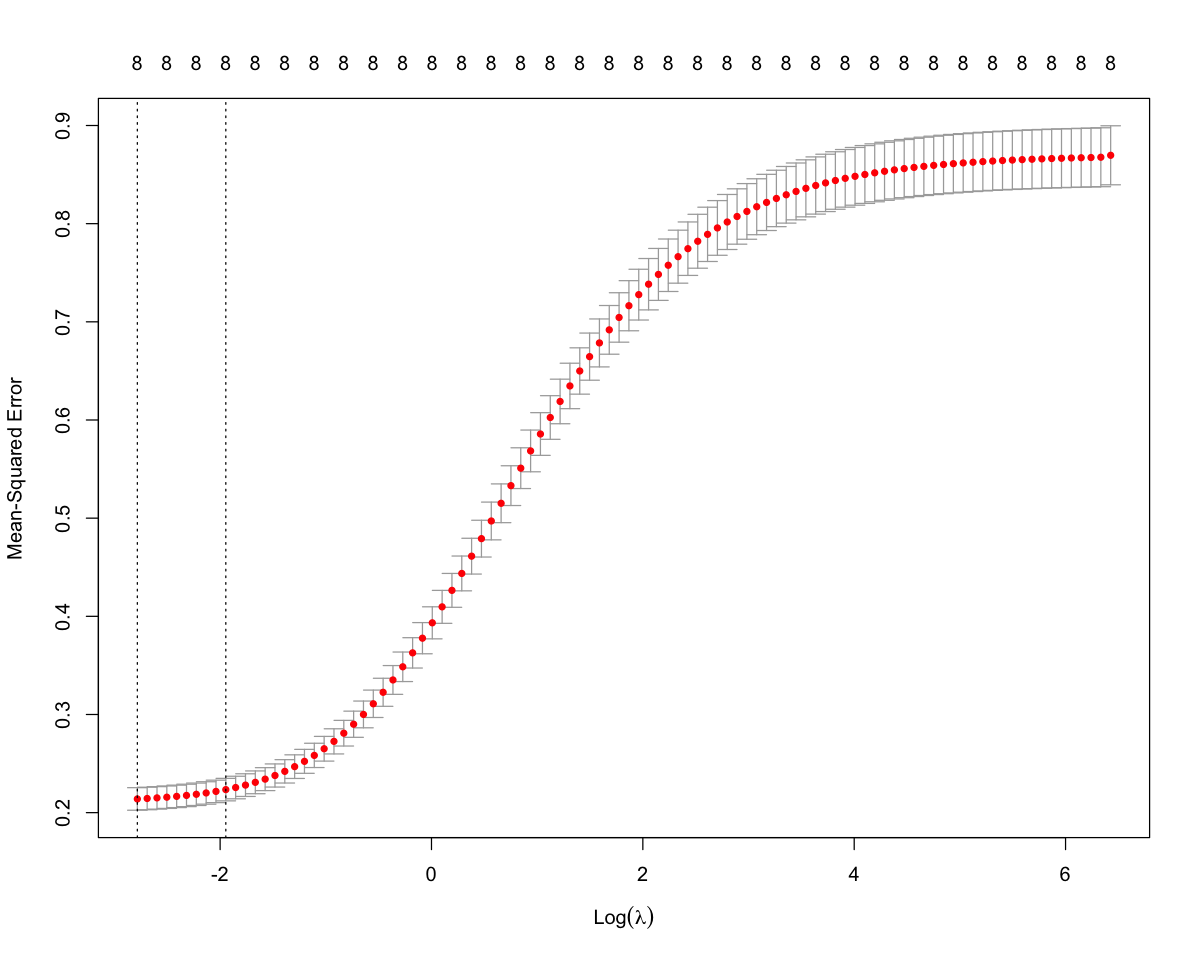

In [23]:
# ridge
set.seed(1234)
ridge_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=0, nfolds=10)
ridge_model
plot(ridge_model)

In [24]:
best_lambda_ridge <- ridge_model$lambda.min
best_lambda_ridge

[1] 0.06182403

In [25]:
best_model_ridge<-glmnet(x=x_train,y =tran_training_set$charges,alpha=0, lambda=best_lambda_ridge)

In [26]:
prediction_ridge <- predict(best_model_ridge, newx = x_test, s = "lambda.min")

In [27]:
actual = tran_testing_set$charges
prediction = prediction_ridge

rmse(actual,prediction)

[1] 0.4119294

In [28]:
length(actual)
length(prediction)

[1] 402

[1] 402

In [29]:
# VS lasso : 0.412977596985591-> comment
# https://stats.stackexchange.com/questions/331782/if-only-prediction-is-of-interest-why-use-lasso-over-ridge/331809#331809
# https://stats.stackexchange.com/questions/357413/why-lasso-yield-a-higher-mse-then-ridge


**6. OLR for comparison**

In [45]:
olr<-lm(tran_training_set$charges ~.,tran_training_set)

In [46]:
prediction_olr<- predict(olr, newx = tran_testing_set)

actual = tran_testing_set$charges
prediction = prediction_olr

rmse(actual,prediction)

Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”


[1] 1.203385

In [44]:
length(actual)
length(prediction)

[1] 402

[1] 936

In [33]:
#???

**7. KNN for comparison**

In [38]:
# reference: https://cran.r-project.org/web/packages/caret/caret.pdf

In [35]:
knn_model_7 = knnreg(x_train, tran_training_set$charges, k = 7)
pred_knn_7 = predict(knn_model_7, x_test)

rmse_knn_7 = rmse(tran_testing_set$charges, pred_knn_7 )
rmse_knn_7

[1] 0.7377994

In [36]:
knn_model_3 = knnreg(x_train, tran_training_set$charges, k = 3)
pred_knn_3 = predict(knn_model_3, x_test)

rmse_knn_3 = rmse(tran_testing_set$charges, pred_knn_3)
rmse_knn_3

[1] 0.7948263